In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# IMPORTS


In [3]:
from IPython.core.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


In [4]:
# Function to create styled headings
def styled_heading(text, background_color='#f0f8ff', text_color='#000000'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        font-family: 'Montserrat', sans-serif;
        color: {text_color};
        padding: 15px;
        font-size: 30px;
        font-weight: bold;
        line-height: 1.2;
        border-radius: 20px 20px 0 0;
        margin: 20px 0;
        box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.2);
        border: 3px dashed {text_color};
    ">
        {text}
    </div>
    """
# Function for displaying data overview with source information
def display_overview_with_source(datasets, heading_bg='#f0f8ff', heading_color='#000000', text_bg='#f0f8ff', text_color='#000000'):
    """
    Displays a comprehensive overview of multiple datasets with labeled sections.
    
    Args:
        datasets (dict): A dictionary where keys are dataset names and values are DataFrames.
        heading_bg (str): Background color for styled headings.
        heading_color (str): Text color for styled headings.
        text_bg (str): Background color for text content.
        text_color (str): Text color for text content.
    """
    import pandas as pd
    from IPython.display import display, HTML
    from io import StringIO
    try:
        for dataset_name, df in datasets.items():
            # Section heading
            display(HTML(styled_heading(f"Overview of {dataset_name} Dataset", background_color=heading_bg, text_color=heading_color)))

            # Display head, tail, and numerical summary
            sections = [
                ("The Head of the Dataset:", df.head(5)),
                ("The Tail of the Dataset:", df.tail(5)),
                ("Numerical Summary of the Data:", df.describe())
            ]
            
            for heading, df_part in sections:
                display(HTML(styled_heading(heading, background_color=heading_bg, text_color=heading_color)))
                display(HTML(df_part.to_html(index=False).replace(
                    '<table border="1" class="dataframe">',
                    f'<table style="border: 8px solid black; margin-bottom: 20px; background-color: {text_bg}; color: {text_color};">'
                ).replace('<td>', f'<td style="color: {text_color}; background-color: {text_bg};">')))
                
            # Print shape data
            display(HTML(styled_heading("Shape of the Dataset:", background_color=heading_bg, text_color=heading_color)))
            shape_details = f"""
            Rows: {df.shape[0]}  
            Columns: {df.shape[1]}
            """
            display(HTML(f"<p style='color: {text_color}; background-color: {text_bg}; padding: 10px; border: 8px solid black;'>{shape_details}</p>"))
            
            # Display dataset info
            display(HTML(styled_heading("Dataset Information:", background_color=heading_bg, text_color=heading_color)))
            buffer = StringIO()
            df.info(buf=buffer)
            buffer.seek(0)
            info_str = buffer.read()
            display(HTML(f"<pre style='color: {text_color}; background-color: {text_bg}; margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px; padding: 10px; border: 8px solid black;'>{info_str}</pre>"))

            # Display null values
            display(HTML(styled_heading("Null Values in the Dataset:", background_color=heading_bg, text_color=heading_color)))
            null_values = (df.isnull().mean()*100).sort_values(ascending = False)
            display(HTML(f"<pre style='color: {text_color}; background-color: {text_bg}; margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px; padding: 10px; border: 8px solid black;'>{null_values.to_string()}</pre>"))

            # Check for duplicates
            display(HTML(styled_heading("Duplicate Records Check:", background_color=heading_bg, text_color=heading_color)))
            duplicates_exist = df.duplicated().any()
            dup_msg = "Duplicates exist in the dataset." if duplicates_exist else "No duplicate records found."
            
            display(HTML(f"<p style='color: {text_color}; background-color: {text_bg}; padding: 10px; border: 8px solid black;'>{dup_msg}</p>"))
    
    except Exception as e:
        display(HTML(f"<div style='color: red; font-weight: bold;'>Error: {str(e)}</div>"))

In [5]:
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays_events_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [6]:
datasets = {'oil_df': oil_df, 
           'holidays_events_df': holidays_events_df,
           'stores_df': stores_df, 
           'train_df': train_df,
           'test_df': test_df, 
           'transactions_df': transactions_df}



display_overview_with_source(datasets)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


date,dcoilwtico
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


date,dcoilwtico
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46
2017-08-30,45.96
2017-08-31,47.26


dcoilwtico
1175.000000
67.714366
25.630476
26.190000
46.405000
53.190000
95.660000
110.620000


date,type,locale,locale_name,description,transferred
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


date,type,locale,locale_name,description,transferred
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False
2017-12-25,Holiday,National,Ecuador,Navidad,False
2017-12-26,Additional,National,Ecuador,Navidad+1,False


date,type,locale,locale_name,description,transferred
350,350,350,350,350,350
312,6,3,24,103,2
2014-06-25,Holiday,National,Ecuador,Carnaval,False
4,221,174,174,10,338


store_nbr,city,state,type,cluster
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


store_nbr,city,state,type,cluster
50,Ambato,Tungurahua,A,14
51,Guayaquil,Guayas,A,17
52,Manta,Manabi,A,11
53,Manta,Manabi,D,13
54,El Carmen,Manabi,C,3


store_nbr,cluster
54.000000,54.000000
27.500000,8.481481
15.732133,4.693395
1.000000,1.000000
14.250000,4.000000
27.500000,8.500000
40.750000,13.000000
54.000000,17.000000


id,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


id,date,store_nbr,family,sales,onpromotion
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


id,store_nbr,sales,onpromotion
3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


id,date,store_nbr,family,onpromotion
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


id,date,store_nbr,family,onpromotion
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
3029399,2017-08-31,9,SEAFOOD,0


id,store_nbr,onpromotion
2.851200e+04,28512.000000,28512.000000
3.015144e+06,27.500000,6.965383
8.230850e+03,15.586057,20.683952
3.000888e+06,1.000000,0.000000
3.008016e+06,14.000000,0.000000
3.015144e+06,27.500000,0.000000
3.022271e+06,41.000000,6.000000
3.029399e+06,54.000000,646.000000


date,store_nbr,transactions
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


date,store_nbr,transactions
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255
2017-08-15,53,932
2017-08-15,54,802


store_nbr,transactions
83488.000000,83488.000000
26.939237,1694.602158
15.608204,963.286644
1.000000,5.000000
13.000000,1046.000000
27.000000,1393.000000
40.000000,2079.000000
54.000000,8359.000000


**we have to delete duplicates for same store, same date, same family**

In [7]:
def drop_duplicates_on_columns(df, subset_cols, keep='first', inplace=False):
    """
    Drop duplicate rows based on a list of columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to clean.
        subset_cols (list): Columns to check for duplicates.
        keep (str): 'first', 'last', or False — same as pandas.
        inplace (bool): Modify the original DataFrame or return a new one.

    Returns:
        pd.DataFrame or None: Cleaned DataFrame if inplace=False, else None.
    """
    if not isinstance(subset_cols, list):
        raise ValueError("subset_cols must be a list of column names.")

    before = df.shape[0]
    df_cleaned = df.drop_duplicates(subset=subset_cols, keep=keep, inplace=inplace)
    after = df.shape[0] if inplace else df_cleaned.shape[0]
    
    print(f"🧹 Dropped {before - after} duplicate rows based on {subset_cols}")

    

In [8]:
drop_duplicates_on_columns(train_df, ['date', 'store_nbr', 'family'], keep = 'first', inplace = True)

🧹 Dropped 0 duplicate rows based on ['date', 'store_nbr', 'family']


**only the oil dataset has null_values.**
**we are going to merge the dataframes. But let's check for a moment the holiday dataset if it's important or not.**

In [9]:
def number_of_category(df, col): 
    return df[col].value_counts(normalize = True)* 100

number_of_category(holidays_events_df, 'type')

type
Holiday       63.142857
Event         16.000000
Additional    14.571429
Transfer       3.428571
Bridge         1.428571
Work Day       1.428571
Name: proportion, dtype: float64

**additional, holidays and event - they are in majority - so we can drop it now. Later!******

> merging the dataframe

In [10]:
merged_df = pd.merge(train_df, oil_df, on = 'date', how = "left")
merged_df = pd.merge(merged_df, stores_df, on = 'store_nbr', how = "left")
merged_df = pd.merge(merged_df, transactions_df, on = ['date', 'store_nbr'], how = "left")

In [11]:
display_overview_with_source({'merged_df': merged_df})

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN


id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2155.0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2155.0
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2155.0
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,2155.0
3000887,2017-08-15,9,SEAFOOD,16.000,0,47.57,Quito,Pichincha,B,6,2155.0


id,store_nbr,sales,onpromotion,dcoilwtico,cluster,transactions
3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,2.072466e+06,3.000888e+06,2.755104e+06
1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00,6.792559e+01,8.481481e+00,1.694602e+03
8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01,2.566633e+01,4.649735e+00,9.632810e+02
0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,1.000000e+00,5.000000e+00
7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.638000e+01,4.000000e+00,1.046000e+03
1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00,5.333000e+01,8.500000e+00,1.393000e+03
2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00,9.580000e+01,1.300000e+01,2.079000e+03
3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.106200e+02,1.700000e+01,8.359000e+03


# Handling the nulls

transactions & dcoilwtico - these cols have nulls. Both are numeric.


In [12]:
def impute_missing_values(df):
    """
    Impute missing values in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame with missing values.
    
    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    # Iterate over columns
    for column in df.columns:
        if df[column].isnull().sum() > 0:  
            if df[column].dtype == 'object':  
                most_frequent_value = df[column].mode()[0]
                df[column].fillna(most_frequent_value, inplace=True)
            elif df[column].dtype in ['int64', 'float64']:  
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
            elif df[column].dtype == 'bool':  
                mode_value = df[column].mode()[0]
                df[column].fillna(mode_value, inplace=True)
    return df

In [13]:
merged_df = impute_missing_values(merged_df)
merged_df.isnull().sum()

/tmp/ipykernel_35/1492669051.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)


id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
transactions    0
dtype: int64

# **having temporal features**

In [14]:
def date_breakdown(df):
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    df['weekday'] = df['date'].dt.dayofweek
    df['weekday_name'] = df['date'].dt.strftime('%A')
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%B')
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    
    return df

In [15]:
merged_df = date_breakdown(merged_df)

# Let's begin the EDA

But first what's the story here? 
-> we have Ecuador, a oil dependent country. We have multiple cities where we have families owning their stores(unique id). The stores have their type, cluster(grouping of similar stores) etc. We have data on sales, onpromotion(pdts discount), transactions. we also have an indicator of economy - oil price. 

What are the questions?
1. economic picture - oil price variation
2. variance across state and city
3. transaction variance
4. categorical analysis of types
5. cluster variance
6. onpromotion and sales variance 

****

let's rename the col first. Terrible name!!

In [16]:
merged_df.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)


In [17]:
def plot_hist(df, col, bins=100):
    """
    Plots a custom histogram using matplotlib.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col (str): Column name for which the histogram is to be plotted.
        bins (int): Number of bins in the histogram.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[col], bins=bins, color='steelblue', edgecolor='black', alpha=0.8)
    
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

****

In [18]:
def plot_bar_percent(df, col, show_pct_labels=True, order=None, palette='pastel'):
    # Get value counts as percentages
    pct = df[col].value_counts(normalize=True).sort_index() * 100
    pct = pct.sort_values(ascending=False) if order is None else pct[order]

    # Plot
    ax = sns.barplot(x=pct.index, y=pct.values, palette=palette)
    plt.title(f'Percentage Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on top of bars
    if show_pct_labels:
        for patch, value in zip(ax.patches, pct.values):
            ax.annotate(f'{value:.1f}%', 
                        (patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(rotation=45)
    plt.tight_layout()
    num_categories = len(pct)
    width = max(6, num_categories * 0.7)
    plt.gcf().set_size_inches(width, 5)
    plt.show()

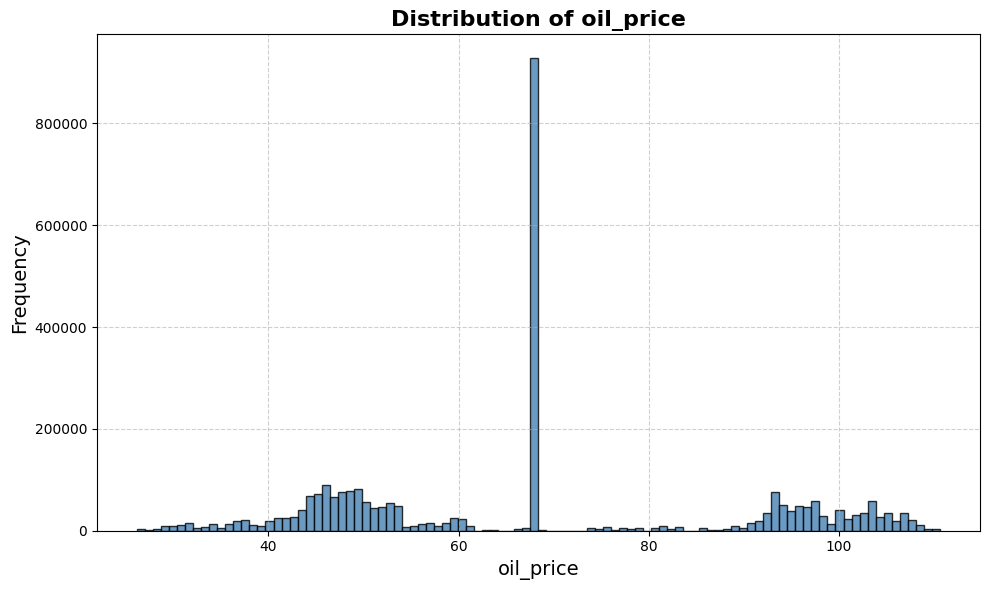

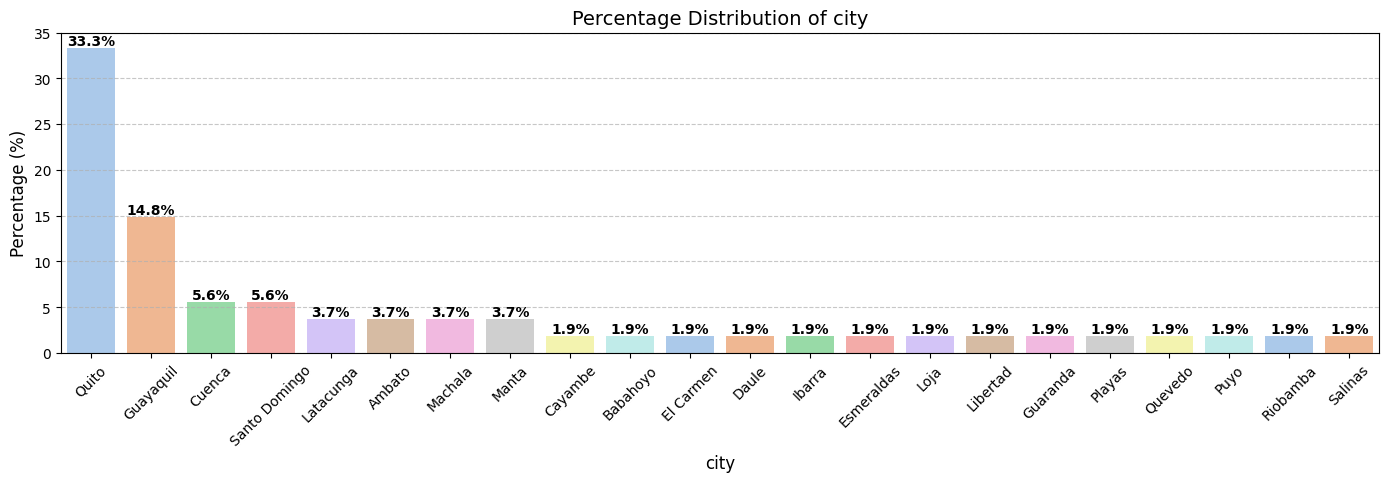

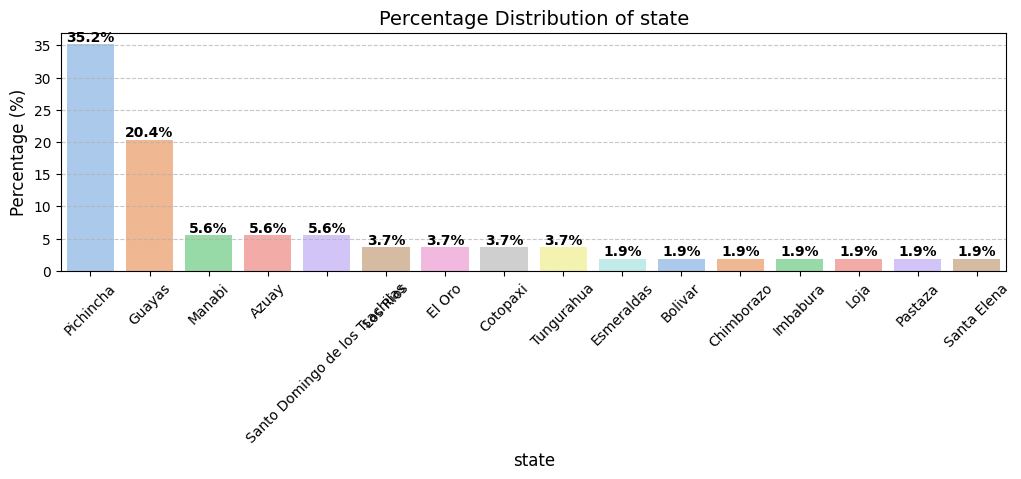

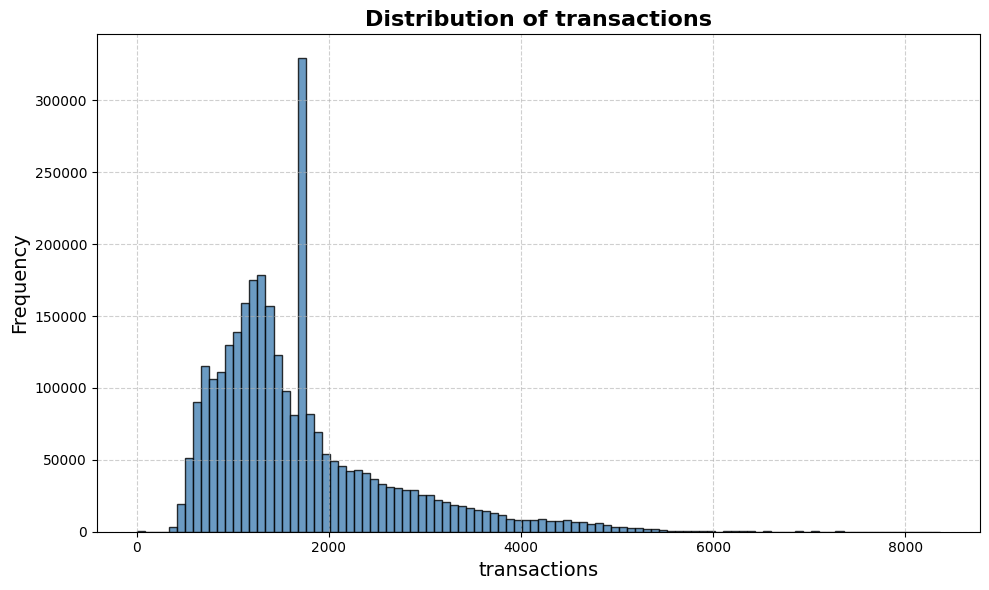

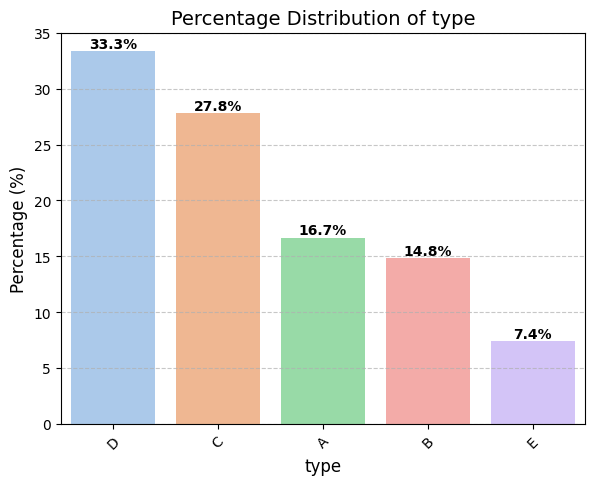

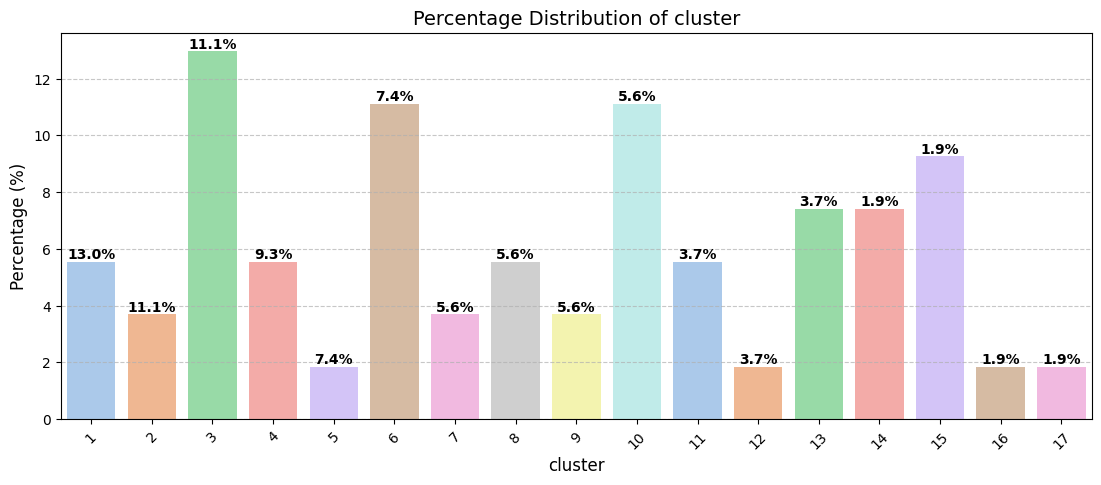

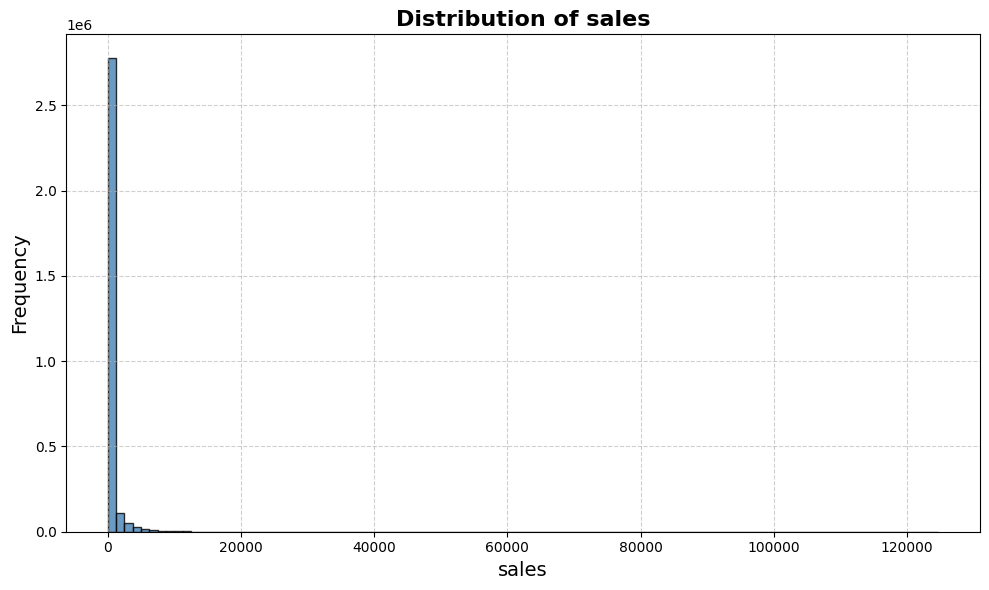

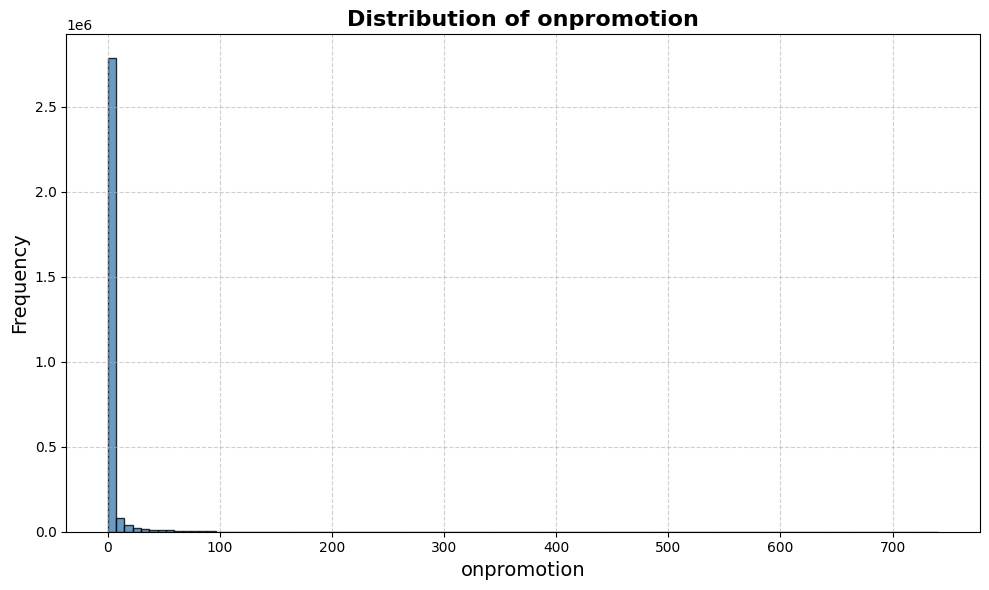

In [19]:
plot_hist(merged_df, 'oil_price', bins = 100)
plot_bar_percent(merged_df, 'city' )
plot_bar_percent(merged_df, 'state' )
plot_hist(merged_df, 'transactions', bins = 100)
plot_bar_percent(merged_df, 'type' )
plot_bar_percent(merged_df, 'cluster' )
plot_hist(merged_df, 'sales', bins = 100)
plot_hist(merged_df, 'onpromotion', bins = 100)

**so it's pretty okay with some outliers >90 and <55 roughly. We can check that. But majority time oil price is constant at around 70**

**Quito is the key city. Guayaquil is next.**

**pichincha and guayas are the key states with max data points. Quito is the captial of pichincha.**

**so most transaction is around 1700 with std = 900**

**but we don't know what those types are. Let's check how they influence sales**

<Axes: xlabel='type'>

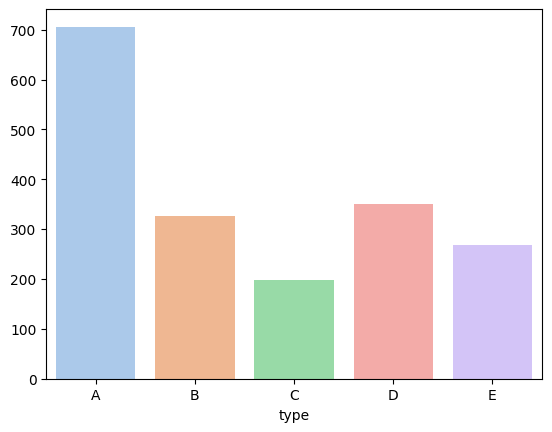

In [20]:
grouped = merged_df.groupby(['type']).sales.mean()
sns.barplot(x = grouped.index, y = grouped.values,palette='pastel' )

**sales vary across type. A type is not most in number but high with mean sales. So influence - yes**

**check the cluster**

In [21]:
merged_df.groupby(['cluster']).sales.mean().sort_values(ascending = False)

cluster
5     1117.245254
14     708.227718
8      647.377856
11     603.507018
17     592.231511
6      342.661732
1      326.163967
12     324.461406
13     324.364108
4      296.572872
9      274.968339
2      260.170621
10     255.897546
16     238.598137
15     199.010111
3      194.416262
7      139.261863
Name: sales, dtype: float64

**It's kinda random. Not any perfect relation that high cluster low/ high sales**

**sales mean is around 360 with high std = 1000 and it's terribly skewed**

**we are log-ing these variables to kill the skewness**

In [22]:
log_columns = ['sales', 'transactions', 'onpromotion']
def log_1p(df, columns): 
    for col in columns: 
        df[col] = np.log1p(df[col])

log_1p(merged_df, log_columns)

**check the correlation**

In [23]:
def plot_numeric_heatmap(df):
    corr = df.select_dtypes(include='number').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap (Numerical Features)')
    plt.tight_layout()
    plt.show()

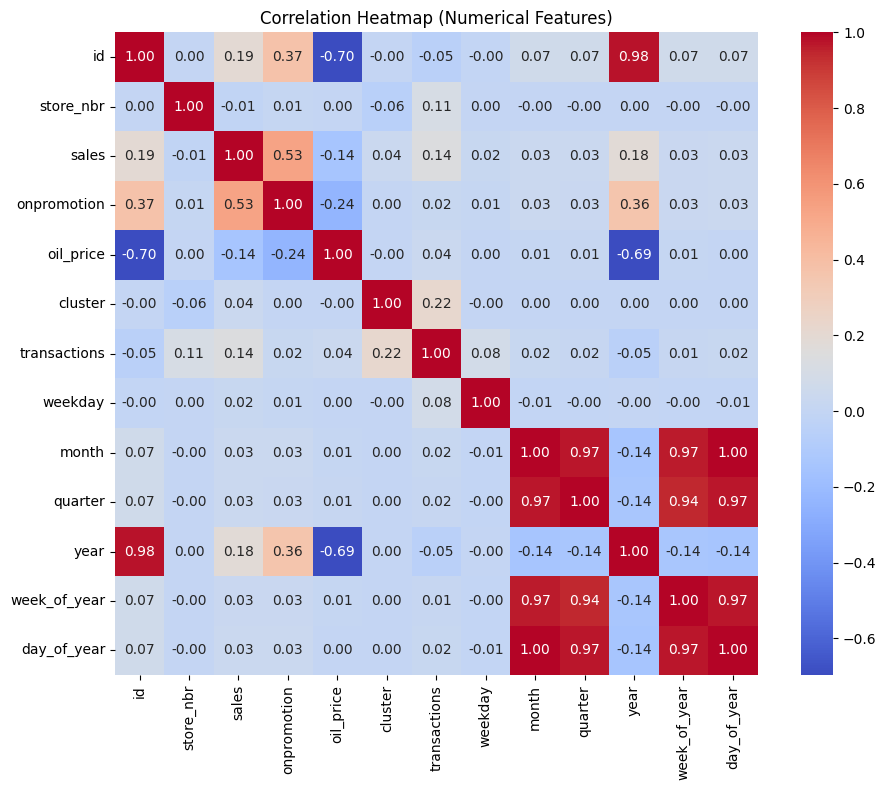

In [24]:
plot_numeric_heatmap(merged_df)

**there isn't too much corr btw variables except with sales = onpromotion (makes sense)**

# **Let's make some temporal features**

In [25]:
total_dates = merged_df['date'].nunique()
print(f"total dates:{total_dates}")

total dates:1684


In [26]:
def add_temporal_features(
    df,
    group_cols,
    target_col,
    lags=[],
    expanding_stats=False,
    rolling_windows=[],
    rolling_stats=['mean'],
    time_col='date'
):
    """
    Adds lagged, expanding, and rolling window features for time series data.

    Parameters:
        df (pd.DataFrame): Your time series DataFrame.
        group_cols (list): Columns to group by (e.g., ['store', 'product']).
        target_col (str): Column on which to compute stats (e.g., 'sales').
        lags (list): List of lag periods to add.
        expanding_stats (bool): Whether to add expanding mean.
        rolling_windows (list): List of rolling window sizes (e.g., [7, 21]).
        rolling_stats (list): Stats to compute over rolling window (e.g., ['mean', 'std']).
        time_col (str): Column used to sort time within groups (e.g., 'date').

    Returns:
        pd.DataFrame: Original DataFrame with new temporal features.
    """
    df = df.copy()

    # make date as datetime 
    df['date'] = pd.to_datetime(df['date'])

    # Ensure proper ordering
    df = df.sort_values(by=group_cols + [time_col])

    # LAG FEATURES
    for lag in lags:
        col_name = f"{target_col}_lag_{lag}"
        df[col_name] = (
            df.groupby(group_cols)[target_col]
            .shift(lag)
        )

    # EXPANDING MEAN
    if expanding_stats:
        exp_col = f"{target_col}_expanding_mean"
        df[exp_col] = (
            df.groupby(group_cols)[target_col]
            .apply(lambda x: x.shift(1).expanding().mean())
            .reset_index(level=group_cols, drop=True)
        )

    # ROLLING WINDOW FEATURES
    for window in rolling_windows:
        for stat in rolling_stats:
            col_name = f"{target_col}_roll_{window}_{stat}"
            df[col_name] = (
                df.groupby(group_cols)[target_col]
                .apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).agg(stat))
                .reset_index(level=group_cols, drop=True)
            )

    return df


In [27]:
merged_new_df = add_temporal_features(merged_df, group_cols = ['store_nbr', 'family'], target_col ='sales', lags = [21, 28], 
                                     expanding_stats = True, rolling_windows = [7, 30, 40], rolling_stats = ['mean'], time_col = 'date')

In [28]:
merged_new_df = merged_new_df.fillna(0)


**Make out data prepared for the model**

**we've log scaled our data. so only we need to take care of categoricals**

**we are using regression. so OHE required for linear reg but for trees we can go on with labelencoding**

# ENCODING

the category col which can be Ohe and will make sense is only the type. states, cities, families can be labelled. and we may skip linear regression model. Otherwise I don't find any meaning converting them into OHEs.

In [29]:
def label_encoder(data, column_names, encoder=None, fit=True):
    """
    Encode categorical columns using LabelEncoder or OneHotEncoder.

    Parameters:
        data (pd.DataFrame): Input DataFrame.
        column_names (list): Columns to encode.
        encoder: Pretrained encoder(s). Can be None, a single encoder, or a dict.
        fit (bool): Whether to fit the encoder(s).

    Returns:
        pd.DataFrame: Transformed DataFrame with encoding applied.
        encoder(s): The fitted encoder or dict of encoders.
    """
    df = data.copy()

    encoders = {} if encoder is None else encoder
    for col in column_names:
        le = LabelEncoder() if encoder is None else encoders[col]
        if fit:
            df[col] = le.fit_transform(df[col])
            encoders[col] = le
        else:
            df[col] = le.transform(df[col])
    return df, encoders


In [30]:
def onehot_encoder(df, column_names, drop_first=True):
    """
    Custom One-Hot Encode multiple categorical columns using pure Pandas.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column_names (list): List of columns to encode.
        drop_first (bool): Drop first category to avoid dummy variable trap.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded columns.
    """
    df = df.copy()
    
    for col in column_names:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first)
        df = df.drop(columns=[col])
        df = pd.concat([df, dummies], axis=1)
    
    return df

In [31]:
col_list = [col for col in merged_new_df.columns if merged_new_df[col].dtype == 'object']
merged_encoded, encoder = label_encoder(merged_new_df, col_list, encoder = None, fit = True)

In [32]:
merged_encoded.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'oil_price', 'city', 'state', 'type', 'cluster', 'transactions',
       'weekday', 'weekday_name', 'month', 'month_name', 'quarter', 'year',
       'week_of_year', 'day_of_year', 'sales_lag_21', 'sales_lag_28',
       'sales_expanding_mean', 'sales_roll_7_mean', 'sales_roll_30_mean',
       'sales_roll_40_mean'],
      dtype='object')

# BASE MODEL TRAINING

In [33]:
def build_training_sets(train_df, cols_to_exclude, target_col, split_frac):
    """
    train_df(dataframe) = training data frame
    cols_to_exclude(list) = dropping ids, target etc. 
    target_col(str) = y(output)
    split (float) = splitting fraction

    returns X_train, X_test, y_train, y_test
    """
    # Separate features and target
    X = train_df.drop(cols_to_exclude, axis=1)
    y = train_df[target_col]

    # Splitting data into training and test sets - respect the date order
    train_size = int(len(train_df) * split_frac)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    return X_train, X_test, y_train, y_test

In [34]:
def evaluate_models(X_train, X_test, y_train, y_test, models: dict, metrics: dict):
    """
    Trains and evaluates multiple models using specified metrics.

    Parameters:
        X_train, X_test, y_train, y_test: Split datasets.
        models (dict): Model name -> model object.
        metrics (dict): metric name -> metric function.

    Returns:
        pd.DataFrame: Rows = models, Columns = metrics.
    """
    results = {}
    for model_name, model in models.items():
        print(f"Training: {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Prediction done for: {model_name}")

        # Clone y_pred and y_test so original stays untouched
        y_pred_trans = np.exp(y_pred) - 1
        y_test_trans = np.exp(y_test) - 1

        # Abs fix for RMSLE only
        y_pred_trans_rmsle = np.abs(y_pred_trans)
        y_test_trans_rmsle = np.abs(y_test_trans)

        scores = {}
        for metric_name, metric_func in metrics.items():
            if metric_name == 'RMSLE':
                scores[metric_name] = metric_func(y_test_trans_rmsle, y_pred_trans_rmsle)
            else:
                scores[metric_name] = metric_func(y_test_trans, y_pred_trans)

            print(f"{model_name} -> {metric_name}: {scores[metric_name]:.4f}")

        results[model_name] = scores

    return pd.DataFrame(results).T

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    'linear': LinearRegression(),
    
    'xgboost': XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        missing=np.nan,
        tree_method='hist',
        enable_categorical=False
    ),
    
    'catboost': CatBoostRegressor(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        verbose=0,
        random_state=42
    ),
    'hist_gbm': HistGradientBoostingRegressor(
        max_iter=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
        # NaN support built-in (float dtypes only!)
    )
}

metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': r2_score,
    'RMSLE': lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
}

In [36]:
def plot_feature_importance(model, feature_names, top_n=20):
    """
    Plot feature importances from a fitted tree-based model.
    Works with XGBoost, LightGBM, CatBoost, and HistGradientBoostingRegressor.
    """
    if hasattr(model, 'feature_importances_'):  # LightGBM, CatBoost, HistGBM
        importances = model.feature_importances_
    elif hasattr(model, 'get_booster'):  # XGBoost
        importances = model.get_booster().get_score(importance_type='gain')
        # Convert to aligned array
        importances = np.array([importances.get(f'f{i}', 0) for i in range(len(feature_names))])
    else:
        raise ValueError("Model type not supported for feature importance.")

    # Create DataFrame for sorting
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(fi_df['feature'], fi_df['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Top Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [37]:
cols_to_exclude = ['id', 'sales','date']
target_col = 'sales'
X_train, X_test, y_train, y_test = build_training_sets(merged_encoded, cols_to_exclude, target_col, split_frac = 0.8)

In [38]:
result = evaluate_models(X_train, X_test, y_train, y_test, models = models, metrics = metrics)
result

Training: linear...
Prediction done for: linear
linear -> MAE: 159.5252
linear -> MSE: 405297.3581
linear -> RMSE: 636.6297
linear -> R2: 0.8596
linear -> RMSLE: 0.5697
Training: xgboost...
Prediction done for: xgboost
xgboost -> MAE: 122.9646
xgboost -> MSE: 276344.6307
xgboost -> RMSE: 525.6849
xgboost -> R2: 0.9043
xgboost -> RMSLE: 0.4384
Training: catboost...
Prediction done for: catboost
catboost -> MAE: 124.3322
catboost -> MSE: 302677.6033
catboost -> RMSE: 550.1614
catboost -> R2: 0.8952
catboost -> RMSLE: 0.4633
Training: hist_gbm...
Prediction done for: hist_gbm
hist_gbm -> MAE: 122.7702
hist_gbm -> MSE: 275863.4954
hist_gbm -> RMSE: 525.2271
hist_gbm -> R2: 0.9045
hist_gbm -> RMSLE: 0.4440


,MAE,MSE,RMSE,R2,RMSLE
linear,159.525232,405297.358096,636.629687,0.859632,0.569699
xgboost,122.964591,276344.630667,525.684916,0.904293,0.438412
catboost,124.332247,302677.603259,550.161434,0.895173,0.463342
hist_gbm,122.770159,275863.495351,525.227089,0.904459,0.444003


# **ft importance**

Plotting for: linear
linear skipped: Model type not supported for feature importance.
Plotting for: xgboost


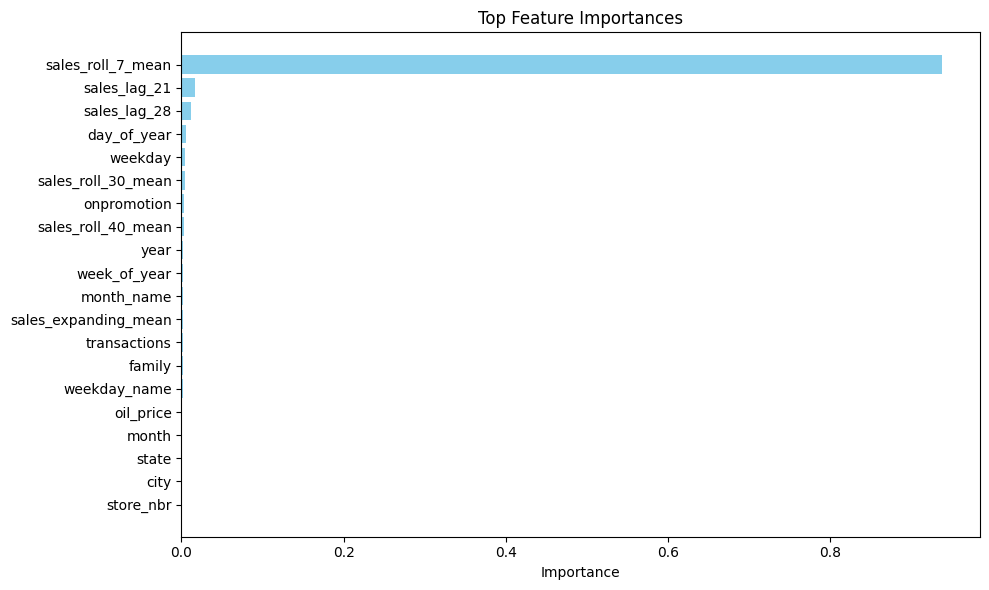

Plotting for: catboost


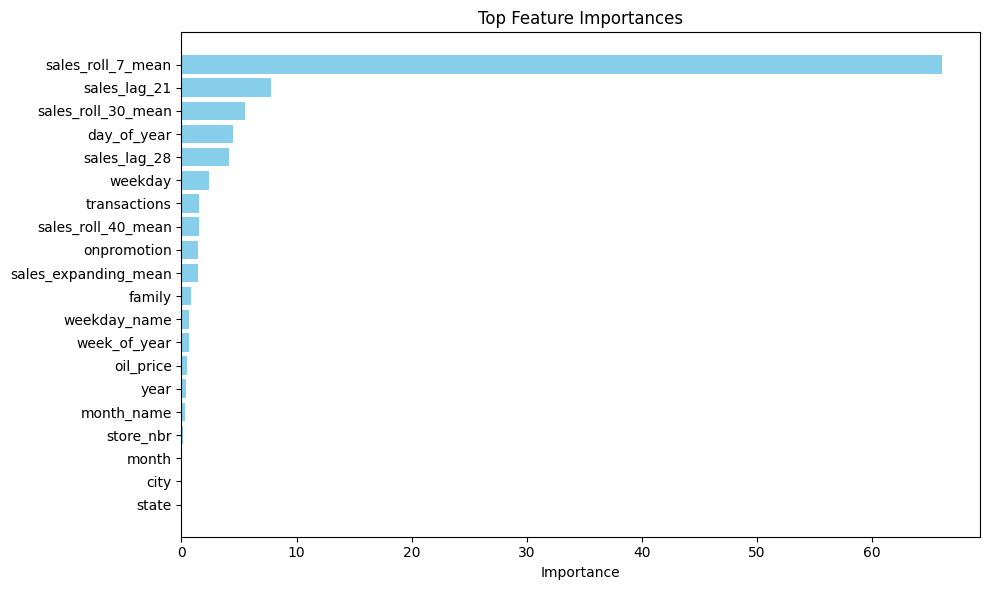

Plotting for: hist_gbm
hist_gbm skipped: Model type not supported for feature importance.


In [39]:
for model_name, model in models.items():
    print(f"Plotting for: {model_name}")
    try:
        plot_feature_importance(model, feature_names=X_train.columns)
    except Exception as e:
        print(f"{model_name} skipped: {e}")

# **drop the redundant cols**

In [40]:
new_feature_space = ['sales_roll_7_mean', 'sales_lag_21', 'sales_roll_30_mean', 'sales_lag_28', 'day_of_year', 'weekday'] 
new_cols_to_exclude = list(set(merged_encoded.columns) - set(new_feature_space))


In [41]:
X_train, X_test, y_train, y_test = build_training_sets(merged_encoded, new_cols_to_exclude, target_col, split_frac = 0.85)
result = evaluate_models(X_train, X_test, y_train, y_test, models = models, metrics = metrics)
result

Training: linear...
Prediction done for: linear
linear -> MAE: 111.3914
linear -> MSE: 215052.8887
linear -> RMSE: 463.7380
linear -> R2: 0.8946
linear -> RMSLE: 0.5543
Training: xgboost...
Prediction done for: xgboost
xgboost -> MAE: 76.5996
xgboost -> MSE: 112268.4005
xgboost -> RMSE: 335.0648
xgboost -> R2: 0.9450
xgboost -> RMSLE: 0.4326
Training: catboost...
Prediction done for: catboost
catboost -> MAE: 85.8602
catboost -> MSE: 135122.1941
catboost -> RMSE: 367.5897
catboost -> R2: 0.9338
catboost -> RMSLE: 0.4541
Training: hist_gbm...
Prediction done for: hist_gbm
hist_gbm -> MAE: 80.9730
hist_gbm -> MSE: 127395.4868
hist_gbm -> RMSE: 356.9250
hist_gbm -> R2: 0.9376
hist_gbm -> RMSLE: 0.4414


,MAE,MSE,RMSE,R2,RMSLE
linear,111.391361,215052.888693,463.737953,0.894590,0.554337
xgboost,76.599582,112268.400456,335.064771,0.944971,0.432632
catboost,85.860194,135122.194110,367.589709,0.933769,0.454071
hist_gbm,80.972984,127395.486754,356.925044,0.937556,0.441413


# **taking only post 2015 data**

In [42]:
merged_encoded_trunc = merged_encoded[merged_encoded['year'] > 2015]
X_train, X_test, y_train, y_test = build_training_sets(merged_encoded_trunc, new_cols_to_exclude, target_col, split_frac = 0.85)
result = evaluate_models(X_train, X_test, y_train, y_test, models = models, metrics = metrics)
result

Training: linear...
Prediction done for: linear
linear -> MAE: 131.7647
linear -> MSE: 278410.9152
linear -> RMSE: 527.6466
linear -> R2: 0.9055
linear -> RMSLE: 0.5311
Training: xgboost...
Prediction done for: xgboost
xgboost -> MAE: 91.6484
xgboost -> MSE: 127480.4484
xgboost -> RMSE: 357.0440
xgboost -> R2: 0.9567
xgboost -> RMSLE: 0.4083
Training: catboost...
Prediction done for: catboost
catboost -> MAE: 103.9601
catboost -> MSE: 159916.1855
catboost -> RMSE: 399.8952
catboost -> R2: 0.9457
catboost -> RMSLE: 0.4246
Training: hist_gbm...
Prediction done for: hist_gbm
hist_gbm -> MAE: 95.4558
hist_gbm -> MSE: 146586.5627
hist_gbm -> RMSE: 382.8662
hist_gbm -> R2: 0.9502
hist_gbm -> RMSLE: 0.4135


,MAE,MSE,RMSE,R2,RMSLE
linear,131.764673,278410.915196,527.646582,0.905498,0.531146
xgboost,91.648356,127480.448417,357.044043,0.956729,0.408289
catboost,103.960066,159916.185488,399.895218,0.945719,0.424633
hist_gbm,95.455776,146586.562678,382.866246,0.950243,0.413482


# **recurring forecasting**

In [43]:
def train_multiple_models(X_train, y_train, feature_space, models_dict):
    """
    Trains multiple models and returns a dict of fitted models.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.ndarray
        Training features.
    y_train : pd.Series or np.ndarray
        Training target.
    feature_space = list of cols
    models_dict : dict
        Dictionary of model_name: model_instance.

    Returns:
    --------
    dict
        Dictionary of model_name: trained_model.
    """
    trained_models = {}
    for name, model in models_dict.items():
        print(f"Training: {name}")
        X_train_ready = X_train[feature_space]
        model.fit(X_train_ready, y_train)
        trained_models[name] = model
    return trained_models

# **Take post 2016 data as 2016 was unstable year for the earthquake.**

In [44]:
merged_trunc = merged_new_df[merged_new_df['year'] > 2016]
X_train, X_test, y_train, y_test = build_training_sets(merged_trunc, cols_to_exclude = ['sales'], target_col = target_col, split_frac = 0.85)


In [45]:
trained_models = train_multiple_models(X_train, y_train, feature_space = new_feature_space, models_dict = models)

Training: linear
Training: xgboost
Training: catboost
Training: hist_gbm


In [46]:
test_df_date_ft = date_breakdown(test_df)
log_1p(test_df_date_ft, ['onpromotion'])


merged_test = pd.concat([merged_df, test_df_date_ft])
merged_test_temporal = add_temporal_features(merged_test, group_cols = ['store_nbr', 'family'], target_col ='sales', lags = [21, 28], 
                                     expanding_stats = True, rolling_windows = [7, 30, 40], rolling_stats = ['mean'], time_col = 'date')



In [47]:
test_temporal = merged_test_temporal[merged_test_temporal['id'].isin(test_df['id'])]

In [48]:
def predict_and_save_submissions(x_test, feature_col, trained_models, id_col='id', target_col='sales'):
    predictions = {}
    x_test_projected = x_test[feature_col].fillna(method = 'bfill').fillna(method = 'ffill')
    for model_name, model in trained_models.items():
        preds = model.predict(x_test_projected)
        exp_preds = np.exp(preds) - 1
        predictions[model_name] = exp_preds.tolist()

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            id_col: x_test[id_col].values,
            target_col: exp_preds
        })

        # Save to CSV
        filename = f"submission_{model_name}.csv"
        submission_df.to_csv(filename, index=False)
        print(f"Saved: {filename}")
    
    return predictions


In [49]:
prediction = predict_and_save_submissions(test_temporal, new_feature_space, trained_models, id_col = 'id', target_col = 'sales')

/tmp/ipykernel_35/1348000713.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_test_projected = x_test[feature_col].fillna(method = 'bfill').fillna(method = 'ffill')


Saved: submission_linear.csv
Saved: submission_xgboost.csv
Saved: submission_catboost.csv
Saved: submission_hist_gbm.csv


In [50]:
np.asarray(prediction['xgboost']).mean()

294.68412884130373

In [51]:
# code flow
# model trained over X_train. 
# create same feature space for X_test -> sales_roll_7mean, sales_lag_21, sales_roll_30_mean etc. 
# predict sale for this data pt 
# add the new data point to data space
# go for next test data point. 
# have the entire predicted data space and calculate the metrics.